# **Import librares**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
import tensorflow as tf
from nltk.stem import SnowballStemmer
from collections import Counter
from textblob import Word 
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import contractions
from nltk.corpus import stopwords
from nltk.corpus import reuters
from nltk.corpus import brown
from nltk.corpus import gutenberg
from nltk.tokenize import RegexpTokenizer
from wordcloud import WordCloud,ImageColorGenerator
import plotly.express as px
import re
import seaborn as sns
from textattack.augmentation import EasyDataAugmenter, EmbeddingAugmenter

2024-03-12 23:08:48.781482: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-12 23:08:48.901055: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-12 23:08:49.332795: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-03-12 23:08:49.332852: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

### **Load data and analyse stats**


In [2]:
dataset = pd.read_csv("train.csv")
print('Total number of sentences', len(dataset['Text']))
dataset['Verdict'].value_counts()

Total number of sentences 22501


-1    14685
 1     5413
 0     2403
Name: Verdict, dtype: int64

data distribution

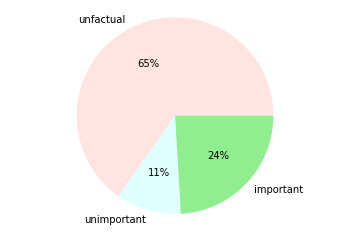

In [3]:
labels=['unfactual', 'unimportant', 'important']
colors = ['mistyrose','lightcyan','lightgreen']
sizes=[dataset['Verdict'].value_counts()[-1],
     dataset['Verdict'].value_counts()[0],
     dataset['Verdict'].value_counts()[1]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors,autopct='%1.0f%%')
ax1.axis('equal')
plt.show() # imbalance 65:24:11

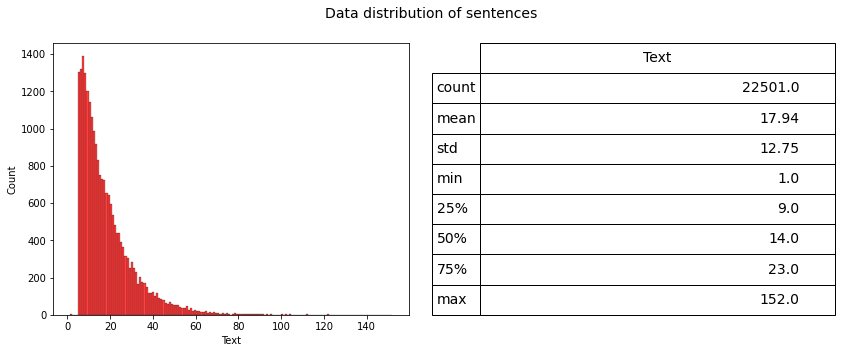

In [4]:
fig = plt.figure(figsize=(14,5))
length = dataset.Text.str.split().apply(len)
# print(length)
ax1 = fig.add_subplot(121)
sns.histplot(length, ax=ax1,color='red')
describe = length.describe().to_frame().round(2)

ax2 = fig.add_subplot(122)
ax2.axis('off')
bbox = [0, 0, 1, 1]
table = ax2.table(colLabels=describe.columns, rowLabels =describe.index, cellText=describe.values, bbox=bbox)
font_size = 14
table.set_fontsize(font_size)
fig.suptitle('Data distribution of sentences', fontsize=14)

plt.show()

Visualize the top k woeds in each class

In [5]:
unfactual = dataset[dataset['Verdict'] == -1]
unimportant = dataset[dataset['Verdict'] == 0] 
important = dataset[dataset['Verdict'] == 1]

unfactual['Words'] = unfactual['Text'].apply(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
unimportant['Words'] = unimportant['Text'].apply(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
important['Words'] = important['Text'].apply(lambda x: RegexpTokenizer(r'\w+').tokenize(x))

/tmp/ipykernel_7127/1174580053.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unfactual['Words'] = unfactual['Text'].apply(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
/tmp/ipykernel_7127/1174580053.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unimportant['Words'] = unimportant['Text'].apply(lambda x: RegexpTokenizer(r'\w+').tokenize(x))
/tmp/ipykernel_7127/1174580053.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [6]:
unfactual['Words']
unimportant['Words']
important['Words']

20       [Here, we, are, with, a, government, that, s, ...
21       [We, ve, been, dealing, with, him, he, s, been...
31       [Now, I, ve, outlined, in, great, detail, a, p...
33       [You, know, we, have, five, percent, of, the, ...
34       [We, re, consuming, 50, percent, of, the, worl...
                               ...                        
22466    [And, I, ll, say, something, about, the, Affor...
22467    [The, Affordable, Care, Act, extended, the, so...
22484    [She, s, raising, the, money, from, the, peopl...
22488                    [We, have, a, depleted, military]
22492    [We, take, care, of, illegal, immigrants, peop...
Name: Words, Length: 5413, dtype: object

In [7]:
k = 10
top = Counter([item for sublist in unfactual['Words'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(k))
temp_positive.columns = ['Most Common Word','num of words']
fig = px.bar(temp_positive, x="num of words", y="Most Common Word", title=f'Top {k} Words in unfactual', orientation='h', 
             width=700, height=700,color='Most Common Word', template='plotly_dark')
fig.show()

In [8]:
top = Counter([item for sub in unimportant['Words'] for item in sub])
temp_positive = pd.DataFrame(top.most_common(k))
temp_positive.columns = ['Most Common Word','num of words']
fig = px.bar(temp_positive, x="num of words", y="Most Common Word", title=f'Top {k} Words in unimportant', orientation='h', 
             width=700, height=700,color='Most Common Word', template='plotly_dark')
fig.show()

In [9]:
top = Counter([item for sub in important['Words'] for item in sub])
temp_positive = pd.DataFrame(top.most_common(k))
temp_positive.columns = ['Most Common Word','num of words']
fig = px.bar(temp_positive, x="num of words", y="Most Common Word", title=f'Top {k} Words in important', orientation='h', 
             width=700, height=700,color='Most Common Word', template='plotly_dark')
fig.show()

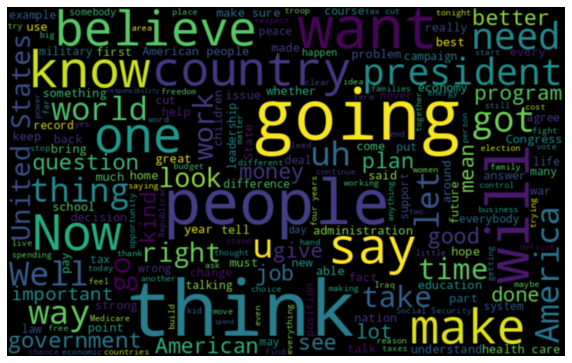

In [11]:
unfactualWords =' '.join([text for text in dataset['Text'][dataset['Verdict'] == -1]])
image = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(unfactualWords)
plt.figure(figsize=(10, 7))
plt.imshow(image, interpolation="bicubic")
plt.axis('off')
plt.show()

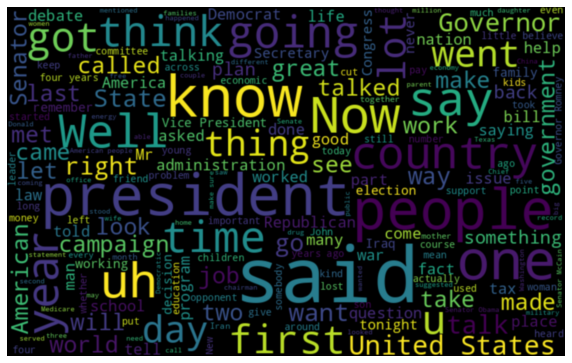

In [13]:
unimportantWords =' '.join([text for text in dataset['Text'][dataset['Verdict'] == 0]])
image = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(unimportantWords)
plt.figure(figsize=(10, 7))
plt.imshow(image, interpolation="bicubic")
plt.axis('off')
plt.show()

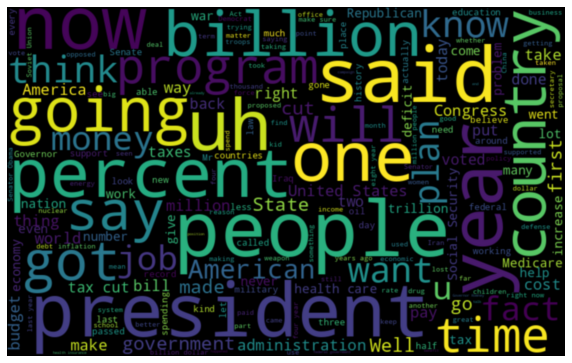

In [14]:
importantWords =' '.join([text for text in dataset['Text'][dataset['Verdict'] == 1]])
image = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(importantWords)
plt.figure(figsize=(10, 7))
plt.imshow(image, interpolation="bicubic")
plt.axis('off')
plt.show()

## Split and observer data distribution

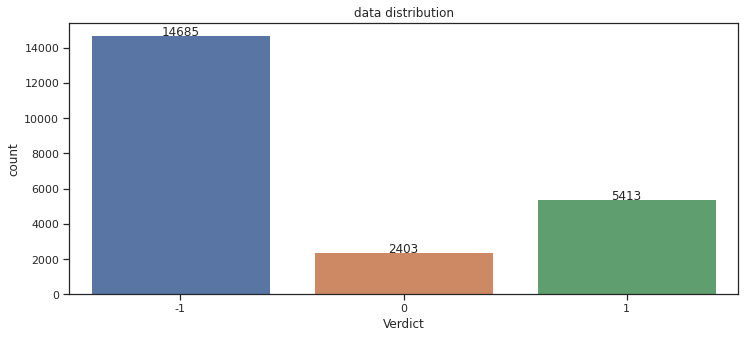

In [21]:
sns.set_theme(style="ticks")

fig, axes = plt.subplots(figsize=(12, 5))

sns.countplot(ax=axes, x='Verdict', data=dataset).set_title('data distribution')

value_counts_train = train_data['Verdict'].value_counts()
for patch in axes.patches:
    height = patch.get_height()
    x = patch.get_x()
    axes.text(x + patch.get_width() / 2., height + 0.1, f'{height}', ha="center")
    
plt.show()